In [1]:
from pyspark.sql import functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
import pandas as pd

import os
os.sys.path.append("../")
from scripts.consumer_model import *


In [2]:
# Create a Spark Session
spark = (
    SparkSession.builder.appName("consumer model")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.execturo.memory", "2g")
    .getOrCreate()
)

24/09/29 16:02:16 WARN Utils: Your hostname, DESKTOP-H6V94HM resolves to a loopback address: 127.0.1.1; using 192.168.0.208 instead (on interface wifi0)
24/09/29 16:02:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/29 16:02:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load data
consumer_info = spark.read.parquet('../data/curated/consumer_info.parquet')
transaction_records = spark.read.parquet('../data/curated/transactions.parquet')
fraudulent_consumer_rate = spark.read.parquet('../data/curated/consumer_fp.parquet')
personal_fraud = spark.read.csv('../data/curated/personal_fraud.csv', header=True, inferSchema=True)
postcode_info = spark.read.csv('../data/curated/postcode_info.csv', header=True, inferSchema=True)

personal_fraud = personal_fraud.drop(personal_fraud.columns[0])
postcode_info = postcode_info.drop(postcode_info.columns[0])

# Consumer Fraud Probability Prediction Model

As there are a lot of missing fraud probability for consumers in the transactions dataset, we would like to use machine learning algorthm to predict the missing values. This version of model predict fraud probability at a consumer level. In other words, each consumer will have only 1 fraud probability and all transactions that the customer made will have the same fraud probability.

Before we start the modeling, we need to prepare our data.

In [4]:
# Join customer with fraud probability with their respective personal informaton
fraudulent_consumer_with_info = consumer_info.join(fraudulent_consumer_rate, on="consumer_id", how="inner")

In [5]:
# Average consumer fraud probability in each postcode and state
fraudulent_consumer_group_by_postcode = fraudulent_consumer_with_info.groupBy(["postcode"]).agg(F.avg("fraud_probability").alias("average_fraud_prob_of_postcode"))

fraudulent_consumer_group_by_state = fraudulent_consumer_with_info.groupBy(["state"]).agg(F.avg("fraud_probability").alias("average_fraud_prob_of_state"))

In [6]:
# Add consumer information to transaction records
consumer_transaction_records = transaction_records.join(consumer_info, on="consumer_id", how="inner")

# Summary statistic of dollar value
consumer_transaction_records.select("dollar_value").summary()

summary,dollar_value
count,11933087
mean,159.82515760274794
stddev,465.5876197570281
min,1.0000012988409446
25%,26.320412455006107
50%,61.77370181047411
75%,148.79382924299938
max,105193.88578925544


From the table above, we can see that the range of the dollar value for all trasactions is very substantial. As we mentioned previously, we only removed transactions with less than $1.00. We kept the extreme value as we believe it's a good factor in determining if a transaction is fraudulent. The above statistic maybe helpful for our model so let's we decide to produce the above summary statistics for all customer that made a transactions

In [7]:
# Analysis of order value, consider the variance of order value and purchase frequency
consumer_transaction_value_analysis =  consumer_transaction_records.groupBy("consumer_id", "state", "postcode") \
                                        .agg(
                                            F.avg("dollar_value").alias("average_dollar_value"),
                                            F.min("dollar_value").alias("min_dollar_value"),
                                            F.max("dollar_value").alias("max_dollar_value"),
                                            F.count("dollar_value").alias("transaction_count"),
                                            F.stddev("dollar_value").alias("stddev_dollar_value")
                                        )

We also think that it's good to compare the consumer's average fraud probability with the state or postcode's average fraud probability that the consumer resides in.

In [8]:
# Get average fraud prob for each consumer
average_fraudulent_consumer_rate = fraudulent_consumer_rate.groupBy("consumer_id").agg(F.avg("fraud_probability").alias("average_fraud_probability"))

In [9]:
fraudulent_consumer_summary = average_fraudulent_consumer_rate \
    .join(consumer_transaction_value_analysis, on="consumer_id", how="left") \
    .join(fraudulent_consumer_group_by_postcode, on="postcode", how="inner") \
    .join(fraudulent_consumer_group_by_state, on="state", how="inner")

fraudulent_consumer_summary

state,postcode,consumer_id,average_fraud_probability,average_dollar_value,min_dollar_value,max_dollar_value,transaction_count,stddev_dollar_value,average_fraud_prob_of_postcode,average_fraud_prob_of_state
NSW,2131,13320,8.8989814859498,158.7981520895688,1.2892815155114417,6473.98926886106,503,393.43363836611053,13.01617593226221,14.956240702420331
TAS,7055,495664,8.294139183975828,158.2972285618389,1.7268067622775944,2182.6192832721863,511,276.74073881006836,11.560844963238429,15.07069162724031
VIC,3093,231660,9.612898301850064,152.26868025171564,1.091640049860114,8578.08242634387,491,449.76948012090526,12.512642535470853,14.960251588536927
SA,5431,302967,8.90068619365561,143.38057938218356,1.2241104535367495,2191.262457678395,483,244.43327602801446,17.052101532733822,15.021945455399033
NT,810,240762,10.591450552633914,187.13752489215838,1.363741971496472,4405.580619592672,513,443.40117450051514,10.85295043657941,15.198876096957566
NSW,1401,98809,12.18474459559366,143.289381930445,1.0173870824855344,2855.4479504691203,501,266.6550401113882,13.716469663169912,14.956240702420331
SA,5462,1488942,16.717652815351453,156.02173127188632,1.1089440402758182,4759.545456044713,488,387.6695123208338,17.575346328578675,15.021945455399033
WA,6023,345890,8.805416100238396,166.22884422970589,1.519104248076888,3815.042664944468,479,318.6087416008098,11.87911440605195,14.74351973488655
WA,6932,620533,26.642591632901244,159.0570097518454,1.1743853090958998,7716.963228145338,514,406.25163083241813,19.997817781009537,14.74351973488655
TAS,7330,334995,31.46703779512172,188.00417571754105,1.0315316951867466,10317.848947502069,478,587.9541850040806,18.395776730544814,15.07069162724031


Since we have the data on personal fraud rate and income from each postcode, we can use it to help predicting consumer fraud probability. We will also create a feature that calculate the proportion of the mean/median income of the consumer's respective location that is used for making transactions. We think that it is unreasonable for a person to spend more than 70% of their annual salary on purchasing items as that would mean they wouldn't have enough money for other neccessity.

In [10]:
# Get infomation about personal fraud and income from external dataset
postcode_info = postcode_info.drop("state", "long", "lat", "lgacode")
fraudulent_consumer_summary = fraudulent_consumer_summary.join(personal_fraud, on="state", how="inner")
fraudulent_consumer_summary = fraudulent_consumer_summary.join(postcode_info, on="postcode", how="inner")

In [11]:
# Get proportion of the money used to purchase item with respect to income
# average income
fraudulent_consumer_summary = fraudulent_consumer_summary.withColumn("Proportion_between_max_order_value_mean_income", F.col("max_dollar_value") / (F.col("mean_income") * 1.5) )
fraudulent_consumer_summary = fraudulent_consumer_summary.withColumn("Proportion_between_max_order_value_median_income", F.col("max_dollar_value") / (F.col("median_income") * 1.5))

# Total income
fraudulent_consumer_summary = fraudulent_consumer_summary.withColumn("Proportion_between_total_order_value_mean_income", F.col("average_dollar_value") * F.col("transaction_count") / (F.col("mean_income") * 1.5))
fraudulent_consumer_summary = fraudulent_consumer_summary.withColumn("Proportion_between_total_order_value_median_income", F.col("average_dollar_value") * F.col("transaction_count") / (F.col("median_income") * 1.5))

In [13]:
window_spec = Window.orderBy(F.col("average_fraud_probability").desc())
summary_rank_by_fraud_prob = fraudulent_consumer_summary.withColumn("rank", F.rank().over(window_spec))
summary_rank_by_fraud_prob.show(20)

24/09/29 16:04:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/29 16:04:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/29 16:04:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/29 16:04:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/29 16:04:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/29 16:04:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/09/29 1

+--------+-----+-----------+-------------------------+--------------------+------------------+------------------+-----------------+-------------------+------------------------------+---------------------------+------------------+-----------+----------+-------------+-----------+----------------------------------------------+------------------------------------------------+------------------------------------------------+--------------------------------------------------+----+
|postcode|state|consumer_id|average_fraud_probability|average_dollar_value|  min_dollar_value|  max_dollar_value|transaction_count|stddev_dollar_value|average_fraud_prob_of_postcode|average_fraud_prob_of_state|victimisation_rate|rse_percent|median_age|median_income|mean_income|Proportion_between_max_order_value_mean_income|Proportion_between_max_order_value_median_income|Proportion_between_total_order_value_mean_income|Proportion_between_total_order_value_median_income|rank|
+--------+-----+-----------+------------

In [14]:
fraudulent_consumer_summary.printSchema()

root
 |-- postcode: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- average_fraud_probability: double (nullable = true)
 |-- average_dollar_value: double (nullable = true)
 |-- min_dollar_value: double (nullable = true)
 |-- max_dollar_value: double (nullable = true)
 |-- transaction_count: long (nullable = true)
 |-- stddev_dollar_value: double (nullable = true)
 |-- average_fraud_prob_of_postcode: double (nullable = true)
 |-- average_fraud_prob_of_state: double (nullable = true)
 |-- victimisation_rate: double (nullable = true)
 |-- rse_percent: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- mean_income: double (nullable = true)
 |-- Proportion_between_max_order_value_mean_income: double (nullable = true)
 |-- Proportion_between_max_order_value_median_income: double (nullable = true)
 |-- Proportion_between_total_order_value_mean_income: double (nullable

# Feature engineering

## Standardizes features

Since the range of the dollar value is high, we decide to normalise to the same scale.

In [15]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.functions import vector_to_array



cols_to_scale = ["min_dollar_value", "max_dollar_value", "stddev_dollar_value","average_dollar_value"]
cols_to_keep_unscaled = [col for col in fraudulent_consumer_summary.columns if col not in cols_to_scale] + ["average_dollar_value"]

assembler = VectorAssembler(inputCols=cols_to_scale, outputCol="features")
sdf_transformed = assembler.transform(fraudulent_consumer_summary)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(sdf_transformed.select("features"))
sdf_scaled = scaler_model.transform(sdf_transformed)
scaled_array_col = vector_to_array(F.col("scaledFeatures"))

# Create new columns for each scaled feature
for i, col in enumerate(cols_to_scale):
    sdf_scaled = sdf_scaled.withColumn(f"scaled_{col}", scaled_array_col[i])

# Combine original Dataframe and the scaled features
dollar_value_df = fraudulent_consumer_summary.select("average_dollar_value")
fraudulent_consumer_summary = sdf_scaled.select(cols_to_keep_unscaled + [f"scaled_{col}" for col in cols_to_scale])


## Features Log transformation 

In [17]:
cols_to_log = ['scaled_average_dollar_value', 'scaled_min_dollar_value',
                'scaled_max_dollar_value', 'scaled_stddev_dollar_value',
                "Proportion_between_max_order_value_mean_income",
                "Proportion_between_max_order_value_median_income",
                "Proportion_between_total_order_value_mean_income",
                "Proportion_between_total_order_value_median_income"
                ] 


for col in cols_to_log:
    fraudulent_consumer_summary = fraudulent_consumer_summary \
        .withColumn(f'{col}', F.when(fraudulent_consumer_summary[col] > 0, F.log(fraudulent_consumer_summary[col])).otherwise(None))

# Visualisation

## Assumptions or Observations:
1. The gender plot shows that there is a similar number of male and female consumers.
2. The number of consumers varies significantly across different states.
3. Consumers make a similar number of purchases on each day of the week, whether it’s a weekday or a weekend.
4. Both fraud probability and the dollar value of an order are strongly right-skewed and should be normalized.
5. Proportion features exhibit a linear relationship with fraud probability but may need transformation to clarify this relationship.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version

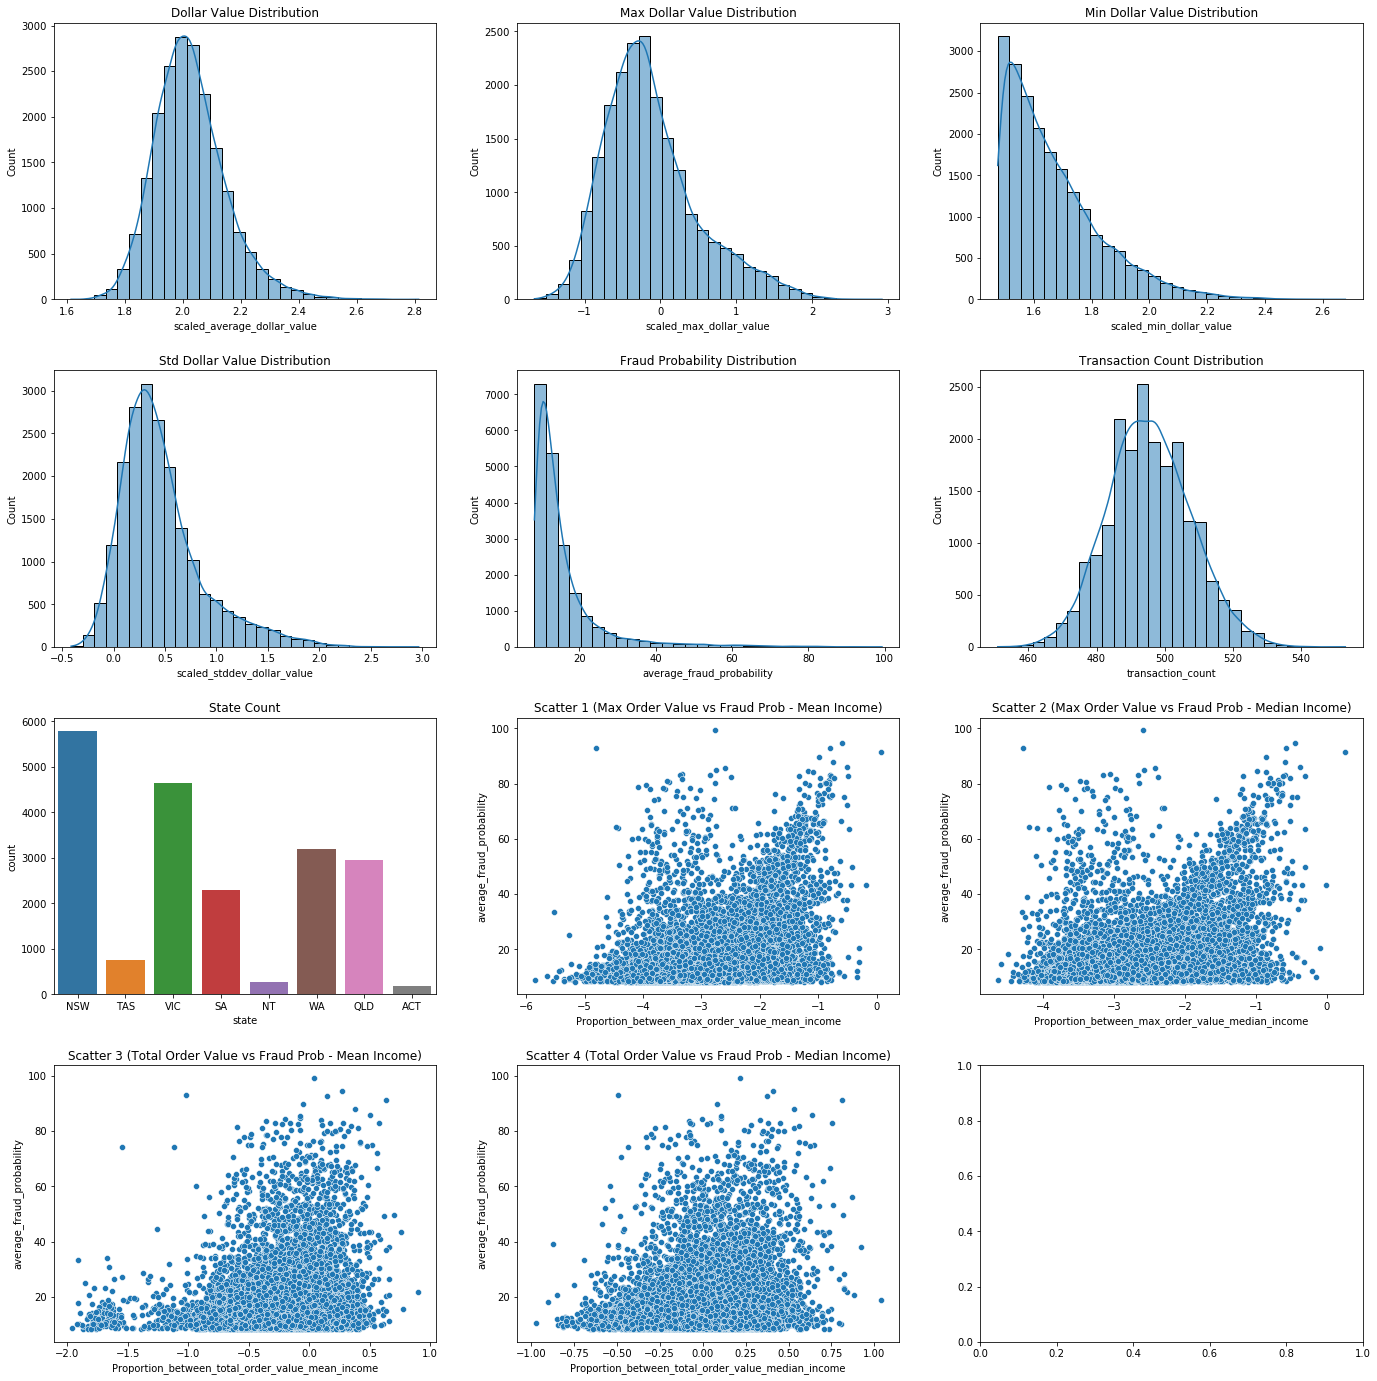

In [18]:
# Convert relevant columns to Pandas
df_pandas = fraudulent_consumer_summary.select(
    "average_fraud_probability", "scaled_average_dollar_value", 
    "scaled_min_dollar_value", "scaled_max_dollar_value", "transaction_count", 
    "median_income", "mean_income", "state", "scaled_stddev_dollar_value",
    "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income", 
    "Proportion_between_total_order_value_mean_income", 
    "Proportion_between_total_order_value_median_income"
).toPandas()

# Define plots in a dictionary for looping
plots = {
    "Dollar Value Distribution": ("scaled_average_dollar_value", "hist"),
    "Max Dollar Value Distribution": ("scaled_max_dollar_value", "hist"),
    "Min Dollar Value Distribution": ("scaled_min_dollar_value", "hist"),
    "Std Dollar Value Distribution": ("scaled_stddev_dollar_value", "hist"),
    "Fraud Probability Distribution": ("average_fraud_probability", "hist"),
    "Transaction Count Distribution": ("transaction_count", "hist"),
    "State Count": ("state", "count"),
    "Scatter 1 (Max Order Value vs Fraud Prob - Mean Income)": ("Proportion_between_max_order_value_mean_income", "scatter1"),
    "Scatter 2 (Max Order Value vs Fraud Prob - Median Income)": ("Proportion_between_max_order_value_median_income", "scatter2"),
    "Scatter 3 (Total Order Value vs Fraud Prob - Mean Income)": ("Proportion_between_total_order_value_mean_income", "scatter3"),
    "Scatter 4 (Total Order Value vs Fraud Prob - Median Income)": ("Proportion_between_total_order_value_median_income", "scatter4")
}
feature_visualisation(df_pandas, plots)


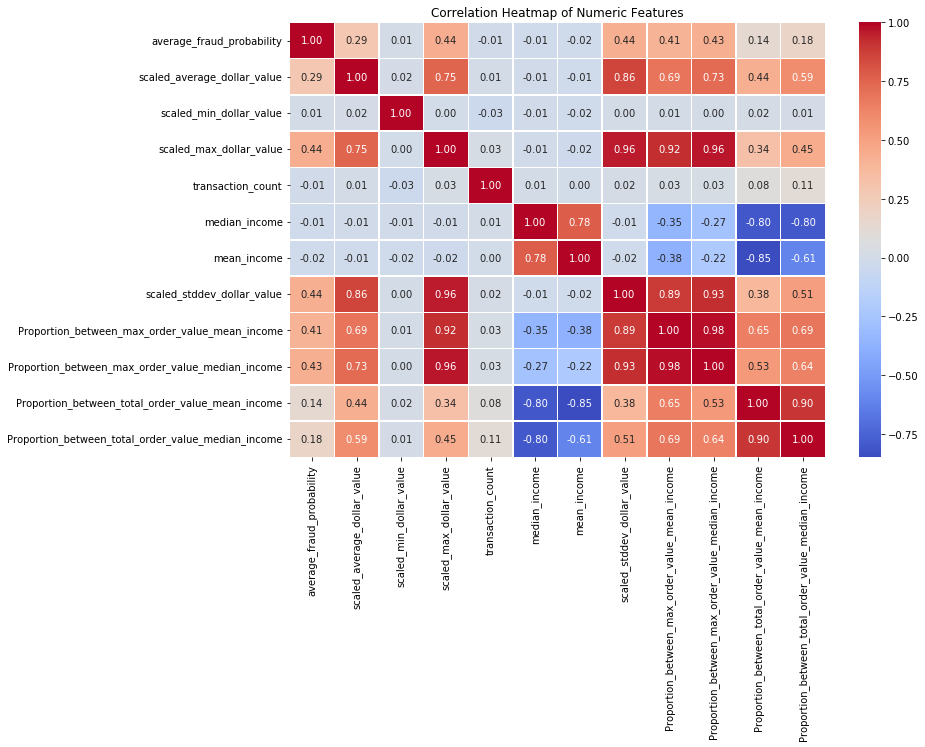

In [19]:
df_pandas = fraudulent_consumer_summary.select(
    "average_fraud_probability", "scaled_average_dollar_value", 
    "scaled_min_dollar_value", "scaled_max_dollar_value", "transaction_count", 
    "median_income", "mean_income", "scaled_stddev_dollar_value",
    "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income", 
    "Proportion_between_total_order_value_mean_income", 
    "Proportion_between_total_order_value_median_income"
).toPandas()
corr_matrix = df_pandas.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


# Idea
1. Time Frequency feature: https://ieeexplore.ieee.org/document/9399421/

# Modelling

In [20]:
# List of features to be used in the model
features = [
    "scaled_average_dollar_value", "scaled_min_dollar_value", 
    "scaled_max_dollar_value", "transaction_count", 
    "average_fraud_prob_of_postcode", "scaled_stddev_dollar_value",
    "Proportion_between_max_order_value_mean_income",
    "Proportion_between_max_order_value_median_income", 
    "Proportion_between_total_order_value_mean_income", 
    "Proportion_between_total_order_value_median_income"
]

features_dt = [
    "scaled_max_dollar_value", 
    "average_fraud_prob_of_postcode"
]

features_rf = [
    "scaled_max_dollar_value", 
    "average_fraud_prob_of_postcode", 
    "Proportion_between_max_order_value_median_income", 
    "scaled_stddev_dollar_value", 
    "Proportion_between_max_order_value_mean_income", 
    "scaled_average_dollar_value"
]

features_lr = [
    "scaled_stddev_dollar_value", 
    "Proportion_between_max_order_value_median_income", 
    "average_fraud_prob_of_postcode", 
    "Proportion_between_max_order_value_mean_income", 
    "Proportion_between_total_order_value_mean_income", 
    "Proportion_between_total_order_value_median_income", 
    "scaled_average_dollar_value"
]


In [21]:
# VectorAssembler to combine the features into a single vector
assembler_dt = VectorAssembler(inputCols=features_dt, outputCol="features")
assembler_rf = VectorAssembler(inputCols=features_rf, outputCol="features")
assembler_lr = VectorAssembler(inputCols=features_lr, outputCol="features")

# Prepare the data
data_dt = assembler_dt.transform(fraudulent_consumer_summary)
data_rf = assembler_rf.transform(fraudulent_consumer_summary)
data_lr = assembler_lr.transform(fraudulent_consumer_summary)

train_data_dt, test_data_dt = data_dt.randomSplit([0.8, 0.2])
train_data_rf, test_data_rf = data_rf.randomSplit([0.8, 0.2])
train_data_lr, test_data_lr = data_lr.randomSplit([0.8, 0.2])


In [22]:
# Define model regressor
dt = DecisionTreeRegressor(labelCol="average_fraud_probability", featuresCol="features")

rf = RandomForestRegressor(labelCol="average_fraud_probability", featuresCol="features")

lr = LinearRegression(labelCol="average_fraud_probability", featuresCol="features")


In [23]:
# Parameter grid
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()


rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 7]) \
    .build()

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


In [24]:
# Evaluator for regression models
rmse_evaluator = RegressionEvaluator(
    labelCol="average_fraud_probability", 
    predictionCol="prediction", 
    metricName="rmse"  
)

r2_evaluator = RegressionEvaluator(
    labelCol="average_fraud_probability",
    predictionCol="prediction",
    metricName="r2" 
)

# Cross-validation 
dt_cv = CrossValidator(
    estimator=dt,
    estimatorParamMaps=dt_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)

rf_cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)

lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=r2_evaluator,
    numFolds=3
)


In [25]:
# Pipeline 
dt_pipeline = Pipeline(stages=[dt_cv])

rf_pipeline = Pipeline(stages=[rf_cv])

lr_pipeline = Pipeline(stages=[lr_cv])


In [26]:
# Fit model
# 6 mins
dt_model = dt_pipeline.fit(train_data_dt)

In [27]:
# 7 mins
rf_model = rf_pipeline.fit(train_data_rf)

In [28]:
# 4 mins
lr_model = lr_pipeline.fit(train_data_lr)

24/09/29 16:22:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/29 16:22:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


# Evaluation

In [29]:
# Make predictions on the test data
dt_predictions = dt_model.transform(test_data_dt)
rf_predictions = rf_model.transform(test_data_rf)
lr_predictions = lr_model.transform(test_data_lr)


dt_rmse = rmse_evaluator.evaluate(dt_predictions)
dt_r2 = r2_evaluator.evaluate(dt_predictions)
print(f"Decision Tree RMSE: {dt_rmse}")
print(f"Decision Tree R2: {dt_r2}")         

rf_rmse = rmse_evaluator.evaluate(rf_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2: {rf_r2}")          

lr_rmse = rmse_evaluator.evaluate(lr_predictions)
lr_r2 = r2_evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Linear Regression R2: {lr_r2}") 



Decision Tree RMSE: 7.31844780871562
Decision Tree R2: 0.35142027468080594


Random Forest RMSE: 7.721693048161061
Random Forest R2: 0.4006489617254819


Linear Regression RMSE: 8.06155684170981
Linear Regression R2: 0.28511551732596985


Best models hyperparameters

In [30]:
best_dt_model = dt_model.stages[-1].bestModel
print(f"Best Decision Tree maxDepth: {best_dt_model._java_obj.getMaxDepth()}")
print(f"Best Decision Tree maxBins: {best_dt_model._java_obj.getMaxBins()}")


best_rf_model = rf_model.stages[-1].bestModel
print(f"Best Random Forest numTrees: {best_rf_model.getNumTrees}")
print(f"Best Random Forest maxDepth: {best_rf_model.getMaxDepth()}")


Best Decision Tree maxDepth: 5
Best Decision Tree maxBins: 32
Best Random Forest numTrees: 20
Best Random Forest maxDepth: 7


### __Feature importances__

In [31]:
feature_names_dt = assembler_dt.getInputCols()
feature_names_rf = assembler_rf.getInputCols()
feature_names_lr = assembler_lr.getInputCols()

`Random forest and decision tree`

In [32]:
best_rf_model = rf_model.stages[0].bestModel
best_dt_model = dt_model.stages[0].bestModel

dt_feature_importances = best_dt_model.featureImportances
rf_feature_importances = best_rf_model.featureImportances

rf_importances_df = pd.DataFrame({
    "Feature": feature_names_rf,
    "Importance": rf_feature_importances.toArray()
}).sort_values(by="Importance", ascending=False)

dt_importances_df = pd.DataFrame({
    "Feature": feature_names_dt,
    "Importance": dt_feature_importances.toArray()
}).sort_values(by="Importance", ascending=False)

print(rf_importances_df)
print()
print(dt_importances_df)

                                            Feature  Importance
1                    average_fraud_prob_of_postcode    0.291955
0                           scaled_max_dollar_value    0.262333
2  Proportion_between_max_order_value_median_income    0.205160
3                        scaled_stddev_dollar_value    0.119258
4    Proportion_between_max_order_value_mean_income    0.084198
5                       scaled_average_dollar_value    0.037096

                          Feature  Importance
0         scaled_max_dollar_value    0.647146
1  average_fraud_prob_of_postcode    0.352854


`Linear regression`

In [33]:

# Get coefficients 
best_lr_model = lr_model.stages[0].bestModel
coefficients = best_lr_model.coefficients
# Get feature names from the VectorAssembler
feature_importances = pd.DataFrame({
    "Feature": feature_names_lr,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

print(feature_importances)


                                             Feature  Coefficient
0                         scaled_stddev_dollar_value    14.352084
2                     average_fraud_prob_of_postcode     0.896326
3     Proportion_between_max_order_value_mean_income     0.317531
1   Proportion_between_max_order_value_median_income     0.013386
4   Proportion_between_total_order_value_mean_income    -0.167838
5  Proportion_between_total_order_value_median_in...    -0.523206
6                        scaled_average_dollar_value   -21.474249


In [34]:
rf_predictions.select("average_fraud_probability", "prediction").show(10000)

+-------------------------+------------------+
|average_fraud_probability|        prediction|
+-------------------------+------------------+
|       15.370318789317658|14.868007857410017|
|       19.398557420170675|16.492379942188062|
|        33.56848183528528|23.452328832827096|
|       16.600460417885063| 12.15784603884007|
|       15.470333861797192| 13.49386492219335|
|       30.377524263247842|19.198336382570115|
|        9.981403025347745|13.931442360212264|
|       13.809615743072019|12.812477940351666|
|       17.130893627119097|18.431610422653417|
|       12.480271821013194| 14.06746833779091|
|        9.152476933187875|14.412272191829098|
|        11.49236509350294|11.820485621838737|
|       37.490771416350036|12.512378224127044|
|       10.645895874644737|11.439669215587001|
|       25.603264481334794|17.883801002255147|
|       12.834259651372829| 12.25964573917502|
|        8.328115205935976|11.773415472463444|
|       15.300489590763313| 12.55388574780393|
|       23.12